In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
data_path = "/kaggle/input/CSC_43M04_EP_challenge/dataset"

train_df = pd.read_csv(f"{data_path}/train_val.csv")
test_df = pd.read_csv(f"{data_path}/test.csv")

def get_image_path(img_id, is_test=False):
    folder = "test" if is_test else "train_val"
    return os.path.join(data_path, folder, f"{img_id}.jpg")



In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder

# Texte
train_df["text"] = train_df["title"].fillna("") + " " + train_df["description"].fillna("")
vectorizer = TfidfVectorizer(max_features=512)
text_features = vectorizer.fit_transform(train_df["text"]).toarray()

# Catégorie
encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")
channel_features = encoder.fit_transform(train_df[["channel"]])

# Année
year_features = train_df[["year"]].values

# Cible
train_df["views_log"] = np.log1p(train_df["views"])
y = train_df["views_log"].values




/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [4]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import os

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


class YouTubeDataset(Dataset):
    def __init__(self, df, text_feat, channel_feat, year_feat, targets, data_path):
        self.df = df
        self.text_feat = text_feat
        self.channel_feat = channel_feat
        self.year_feat = year_feat
        self.targets = targets
        self.data_path = data_path

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.df.iloc[idx]["id"]
        img_path = os.path.join(self.data_path, "train_val", f"{img_id}.jpg")

        image = Image.open(img_path).convert("RGB")
        image = transform(image)

        meta_features = np.concatenate([
            self.text_feat[idx],
            self.channel_feat[idx],
            self.year_feat[idx]
        ])

        return image, torch.tensor(meta_features, dtype=torch.float32), torch.tensor(self.targets[idx], dtype=torch.float32)


In [5]:
import torch
import torch.nn as nn

class YouTubeModel(nn.Module):
    def __init__(self, meta_input_dim, image_size=128):
        super().__init__()

        # CNN to extract features from thumbnails
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),     # (B,3,H,W) -> (B,32,H,W)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),                                # -> (B,32,H/2,W/2)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),    # -> (B,64,H/2,W/2)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),                                # -> (B,64,H/4,W/4)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),   # -> (B,128,H/4,W/4)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.AdaptiveAvgPool2d((4, 4)),                   # -> (B,128,4,4)

            nn.Flatten()                                    # -> (B,128*4*4)
        )


        self.image_output_dim = 128 * 4 * 4

        # Final regressor that combines image + metadata
        self.fc = nn.Sequential(
            nn.Linear(self.image_output_dim + meta_input_dim, 512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )
        self.meta_norm = nn.LayerNorm(meta_input_dim)

    def forward(self, image, meta):
        img_feat = self.cnn(image)
        meta = self.meta_norm(meta)
        x = torch.cat([img_feat, meta], dim=1)
        return self.fc(x).squeeze(1)


In [6]:
import torch
import torch.nn as nn

class YouTubeModel_upgrade1(nn.Module):
    def __init__(self, meta_input_dim, image_size=128):
        super().__init__()

        # CNN to extract features from thumbnails
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),     # (B,3,H,W) -> (B,32,H,W)
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),                                # -> (B,32,H/2,W/2)

            nn.Conv2d(32, 64, kernel_size=3, padding=1),    # -> (B,64,H/2,W/2)
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),                                # -> (B,64,H/4,W/4)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),   # -> (B,128,H/4,W/4)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1),
            nn.AdaptiveAvgPool2d((4, 4)),                   # -> (B,128,4,4)

            nn.Flatten()                                    # -> (B,128*4*4)
        )


        self.image_output_dim = 128 * 4 * 4

        # Final regressor that combines image + metadata
        self.fc = nn.Sequential(
            nn.Linear(self.image_output_dim + 64, 512),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )
        self.meta_mlp = nn.Sequential(
            nn.LayerNorm(meta_input_dim),
            nn.Linear(meta_input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64)  
        )

    def forward(self, image, meta):
        img_feat = self.cnn(image)
        meta_feat = self.meta_mlp(meta)  
        x = torch.cat([img_feat, meta_feat], dim=1)
        return self.fc(x).squeeze(1)


In [7]:
class YouTubeModel_upgrade2_attention(nn.Module):
    def __init__(self, meta_input_dim, image_size=128, d_model=128, patch_size=16, nhead=4, num_layers=2):
        super().__init__()
        self.d_model = d_model
        self.image_size = image_size
        self.patch_size = patch_size
        self.output_attentions = False 
        # Patch embedding
        self.patch_embed = nn.Conv2d(3, d_model, kernel_size=patch_size, stride=patch_size)
        self.num_patches = (image_size // patch_size) ** 2

        # Meta feature processing
        self.meta_token = nn.Sequential(
            nn.LayerNorm(meta_input_dim),
            nn.Linear(meta_input_dim, d_model),
            nn.ReLU(),
            nn.Linear(d_model, d_model)
        )
        # Positional embeddings
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, d_model))
        
        # Transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            dim_feedforward=d_model*4)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Prediction head
        self.head = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Linear(d_model, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1))

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)

    def forward(self, image, meta, output_attentions=False):
        self.output_attentions = output_attentions
        
        # 1. Image patch processing
        x = self.patch_embed(image)  # [B, D, H', W']
        x = x.flatten(2).transpose(1, 2)  # [B, N_patches, D]
        
        # 2. Meta feature processing
        meta_tok = self.meta_token(meta).unsqueeze(1)  # [B, 1, D]
        
        # 3. Combine tokens
        tokens = torch.cat([meta_tok, x], dim=1)  # [B, N_patches+1, D]
        tokens = tokens + self.pos_embed[:, :tokens.size(1)]
        
        # 4. Transformer processing
        if self.output_attentions:
            
            attentions = []
            x = tokens
            for layer in self.transformer.layers:
                x, attn = layer(x, output_attentions=True)
                attentions.append(attn)
            x = self.transformer.norm(x)
        else:
            x = self.transformer(tokens)
        
        # 5. Prediction
        output = self.head(x[:, 0]).squeeze(1)
        
        if self.output_attentions:
            return output, attentions
        return output

In [8]:
import torch
import numpy as np
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import shap

X_train, X_val, idx_train, idx_val = train_test_split(
    np.arange(len(train_df)), np.arange(len(train_df)), test_size=0.1, random_state=42)

train_dataset = YouTubeDataset(train_df.iloc[idx_train], text_features[idx_train], channel_features[idx_train], year_features[idx_train], y[idx_train], data_path)
val_dataset = YouTubeDataset(train_df.iloc[idx_val], text_features[idx_val], channel_features[idx_val], year_features[idx_val], y[idx_val], data_path)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

def train_model_with_early_stopping(
    model, 
    train_loader, 
    val_loader, 
    loss_fn,
    optimizer,
    max_epochs=100,
    patience=2,
    min_epochs=10,
    lr_scheduler=None,
    device='cuda'
):
    # Early stopping variables
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_weights = None
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': []
    }

    for epoch in range(max_epochs):
        # Training phase
        model.train()
        train_losses = []
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{max_epochs} [train]")
        for images, metas, targets in pbar:
            images, metas, targets = (
                images.to(device, non_blocking=True),
                metas.to(device, non_blocking=True),
                targets.to(device, non_blocking=True)
            )
            optimizer.zero_grad()
            preds = model(images, metas)
            loss = loss_fn(preds, targets)
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
            pbar.set_postfix({"train_loss": np.mean(train_losses)})
        
        # Validation phase
        model.eval()
        val_losses = []
        with torch.no_grad():
            for images, metas, targets in val_loader:
                images, metas, targets = (
                    images.to(device, non_blocking=True),
                    metas.to(device, non_blocking=True),
                    targets.to(device, non_blocking=True))
                
                preds = model(images, metas)
                val_losses.append(loss_fn(preds, targets).item())
        
        # Calculate epoch metrics
        train_loss = np.mean(train_losses)
        val_loss = np.mean(val_losses)
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        
        # Update learning rate scheduler if available
        if lr_scheduler:
            if isinstance(lr_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_scheduler.step(val_loss)
            else:
                lr_scheduler.step()
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_weights = model.state_dict().copy()  # Save best weights
        else:
            epochs_no_improve += 1
        
        print(f"Epoch {epoch+1}: "
              f"Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Best Val: {best_val_loss:.4f}")
        
        # Early stopping condition
        if epoch >= min_epochs and epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs!")
            print(f"No improvement for {patience} consecutive epochs.")
            break
    
    # Restore best model weights
    if best_model_weights:
        model.load_state_dict(best_model_weights)
    
    return model, history

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
model = YouTubeModel_upgrade2_attention(
    meta_input_dim=text_features.shape[1] + channel_features.shape[1] + 1
).to(device)

# Define optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_fn = nn.HuberLoss()

# Optional: Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2, verbose=True
)

# Run training with early stopping
trained_model, history = train_model_with_early_stopping(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    max_epochs=200,      # Maximum possible epochs
    patience=4,          # Stop if no improvement for 4 epochs
    min_epochs=3,       # Minimum epochs before checking for early stop
    lr_scheduler=scheduler,
    device=device
)

The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.


Epoch 1/200 [train]:   0%|          | 0/436 [00:00<?, ?it/s]

Epoch 1: Train Loss: 2.4861, Val Loss: 1.3849, Best Val: 1.3849


Epoch 2/200 [train]:   0%|          | 0/436 [00:00<?, ?it/s]

Epoch 2: Train Loss: 1.4062, Val Loss: 1.3576, Best Val: 1.3576


Epoch 3/200 [train]:   0%|          | 0/436 [00:00<?, ?it/s]

Epoch 3: Train Loss: 1.3738, Val Loss: 1.3141, Best Val: 1.3141


Epoch 4/200 [train]:   0%|          | 0/436 [00:00<?, ?it/s]

Epoch 4: Train Loss: 1.3841, Val Loss: 1.2837, Best Val: 1.2837


Epoch 5/200 [train]:   0%|          | 0/436 [00:00<?, ?it/s]

Epoch 5: Train Loss: 1.3652, Val Loss: 1.3316, Best Val: 1.2837


Epoch 6/200 [train]:   0%|          | 0/436 [00:00<?, ?it/s]

Epoch 6: Train Loss: 1.3659, Val Loss: 1.2838, Best Val: 1.2837


Epoch 7/200 [train]:   0%|          | 0/436 [00:00<?, ?it/s]

Epoch 7: Train Loss: 1.3484, Val Loss: 1.3096, Best Val: 1.2837


Epoch 8/200 [train]:   0%|          | 0/436 [00:00<?, ?it/s]

Epoch 8: Train Loss: 1.3520, Val Loss: 1.3078, Best Val: 1.2837

Early stopping triggered after 8 epochs!
No improvement for 4 consecutive epochs.


In [9]:
test_df["text"] = test_df["title"].fillna("") + " " + test_df["description"].fillna("")

text_features_test = vectorizer.transform(test_df["text"]).toarray()
channel_features_test = encoder.transform(test_df[["channel"]])
year_features_test = test_df[["year"]].values



class YouTubeTestDataset(Dataset):
    def __init__(self, df, text_feat, channel_feat, year_feat,  data_path):
        self.df = df
        self.text_feat = text_feat
        self.channel_feat = channel_feat
        self.year_feat = year_feat
        self.data_path = data_path

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_id = self.df.iloc[idx]["id"]
        img_path = os.path.join(self.data_path, "test", f"{img_id}.jpg")
        image = Image.open(img_path).convert("RGB")
        image = transform(image)

        meta = np.concatenate([
            self.text_feat[idx],
            self.channel_feat[idx],
            self.year_feat[idx]
        ])
        return image, torch.tensor(meta, dtype=torch.float32)



test_dataset = YouTubeTestDataset(test_df, text_features_test, channel_features_test, year_features_test, data_path)
test_loader = DataLoader(test_dataset, batch_size=64)

model.eval()
predictions = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

with torch.no_grad():
    for images, metas in tqdm(test_loader, desc="🔍 Predicting"):
        images, metas = images.to(device), metas.to(device)
        preds = model(images, metas)
        predictions.extend(preds.cpu().numpy())

views_pred = np.expm1(predictions).astype(int)

submission = pd.DataFrame({
    "ID": test_df["id"],
    "views": views_pred
})

submission.to_csv("/kaggle/working/submission.csv", index=False)




🔍 Predicting:   0%|          | 0/54 [00:00<?, ?it/s]

In [10]:
import torch
import numpy as np
import shap
import matplotlib.pyplot as plt
from tqdm import tqdm

class MinimalSHAPExplainer:
    def __init__(self, model, device='cpu'):  
        self.model = model.to(device)
        self.device = device
        self.model.eval()
    
    def analyze_metas_only(self, meta_samples, fixed_image, n_samples=5):
        """
        Analyze only meta features using a fixed image to minimize memory usage
        """
        background = meta_samples[:1].to(self.device)
        
        # Create prediction function
        def predict_fn(metas):
            metas = torch.from_numpy(metas).float().to(self.device)
            images = fixed_image.expand(len(metas), -1, -1, -1)
            with torch.no_grad():
                return self.model(images, metas).cpu().numpy()
        
        # Initialize explainer
        explainer = shap.KernelExplainer(
            model=predict_fn,
            data=background.cpu().numpy()
        )
        
        # Calculate SHAP values for first n_samples
        test_metas = meta_samples[:n_samples].cpu().numpy()
        shap_values = explainer.shap_values(test_metas)
        
        # Visualize
        self._plot_metas(shap_values, test_metas)
        
        return shap_values
    
    def analyze_key_features(self, image_samples, meta_samples, n_samples=3, n_features=5):
        """
        Analyze only the top n features to save memory
        """
        # First identify most important features with a small sample
        _, initial_shap = self.analyze_metas_only(meta_samples, image_samples[0], 2)
        top_features = np.argsort(np.abs(initial_shap).mean(0))[-n_features:][::-1]
        
        # Now analyze just these features
        def predict_fn(feature_subset):
            # Create full meta array with just these features varying
            full_metas = meta_samples[:1].clone().expand(len(feature_subset), -1)
            full_metas[:, top_features] = torch.from_numpy(feature_subset).float().to(self.device)
            
            with torch.no_grad():
                return self.model(image_samples[:1].expand(len(feature_subset), -1, -1, -1), 
                        full_metas).cpu().numpy()
        
        explainer = shap.KernelExplainer(
            model=predict_fn,
            data=meta_samples[:1, top_features].cpu().numpy()
        )
        
        test_data = meta_samples[:n_samples, top_features].cpu().numpy()
        shap_values = explainer.shap_values(test_data)
        
        # Visualize
        self._plot_key_features(shap_values, test_data, top_features)
        
        return shap_values, top_features
    
    def _plot_metas(self, shap_values, sample_metas):
        """Plot top meta features only"""
        plt.figure(figsize=(10, 4))
        shap.summary_plot(
            shap_values,
            sample_metas,
            feature_names=[f"meta_{i}" for i in range(sample_metas.shape[1])],
            plot_type='bar',
            max_display=10,  # Show only top 10 features
            show=False
        )
        plt.title("Top Meta Features SHAP Values")
        plt.tight_layout()
        plt.show()
    
    def _plot_key_features(self, shap_values, sample_metas, feature_indices):
        """Plot only the selected key features"""
        plt.figure(figsize=(10, 4))
        shap.summary_plot(
            shap_values,
            sample_metas,
            feature_names=[f"meta_{i}" for i in feature_indices],
            plot_type='bar',
            show=False
        )
        plt.title(f"Top {len(feature_indices)} Important Features")
        plt.tight_layout()
        plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

The figure layout has changed to tight


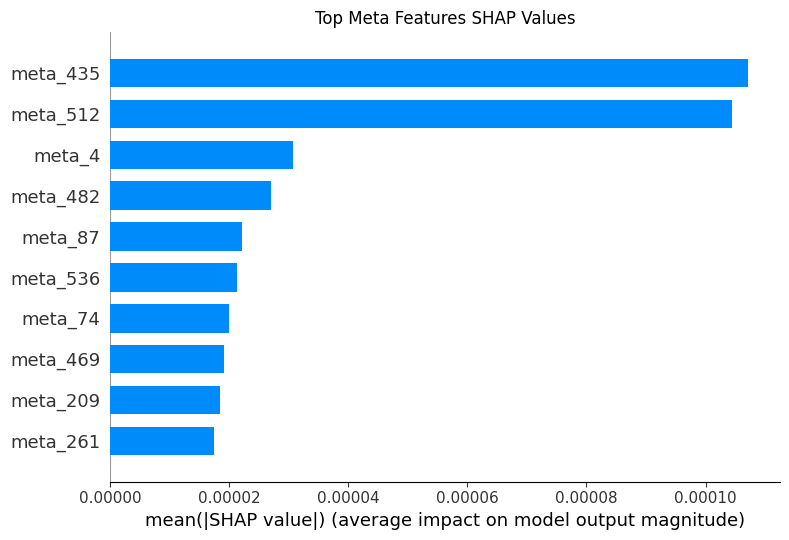

In [11]:
explainer = MinimalSHAPExplainer(model)

# Use first image as fixed reference
sample_images, sample_metas, _ = next(iter(val_loader))
fixed_image = sample_images[0:1].to(explainer.device)

# Analyze only meta features
shap_values = explainer.analyze_metas_only(
    sample_metas, 
    fixed_image,
    n_samples=10  # Start with just 3 samples
)

In [12]:
print("Text features shape:", text_features.shape)
print("Channel features shape:", channel_features.shape)
print("Year features shape:", year_features.shape)

Text features shape: (15482, 512)
Channel features shape: (15482, 46)
Year features shape: (15482, 1)


In [19]:
import pandas as pd
import numpy as np

# Create the meta features DataFrame
meta_features = np.concatenate([
    text_features,          # From TF-IDF (512 features)
    channel_features,       # From OneHotEncoding (n_channels features)
    year_features           # Raw year values (1 feature)
], axis=1)

# Create column names
text_columns = [f"text_{i}" for i in range(text_features.shape[1])]
channel_columns = [f"channel_{cat}" for cat in encoder.categories_[0]]
year_column = ["year"]

all_columns = text_columns + channel_columns + year_column

# Create the meta_df
meta_df = pd.DataFrame(meta_features, columns=all_columns)

# Add the target variable
meta_df["views_log"] = y

           text_435  channel_UC-1rx8j9Ggp8mp4uD0ZdEIA        text_4  \
count  15482.000000                      15482.000000  15482.000000   
mean       0.107968                          0.327154      0.030189   
std        0.202322                          0.469189      0.054549   
min        0.000000                          0.000000      0.000000   
25%        0.000000                          0.000000      0.000000   
50%        0.000000                          0.000000      0.000000   
75%        0.074111                          1.000000      0.044476   
max        0.715949                          1.000000      0.863987   

           text_482       text_87  channel_UCTMt7iMWa7jy0fNXIktwyLA  \
count  15482.000000  15482.000000                      15482.000000   
mean       0.024261      0.134515                          0.032489   
std        0.042382      0.099928                          0.177301   
min        0.000000      0.000000                          0.000000   
25%  

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


ValueError: num must be an integer with 1 <= num <= 6, not 7

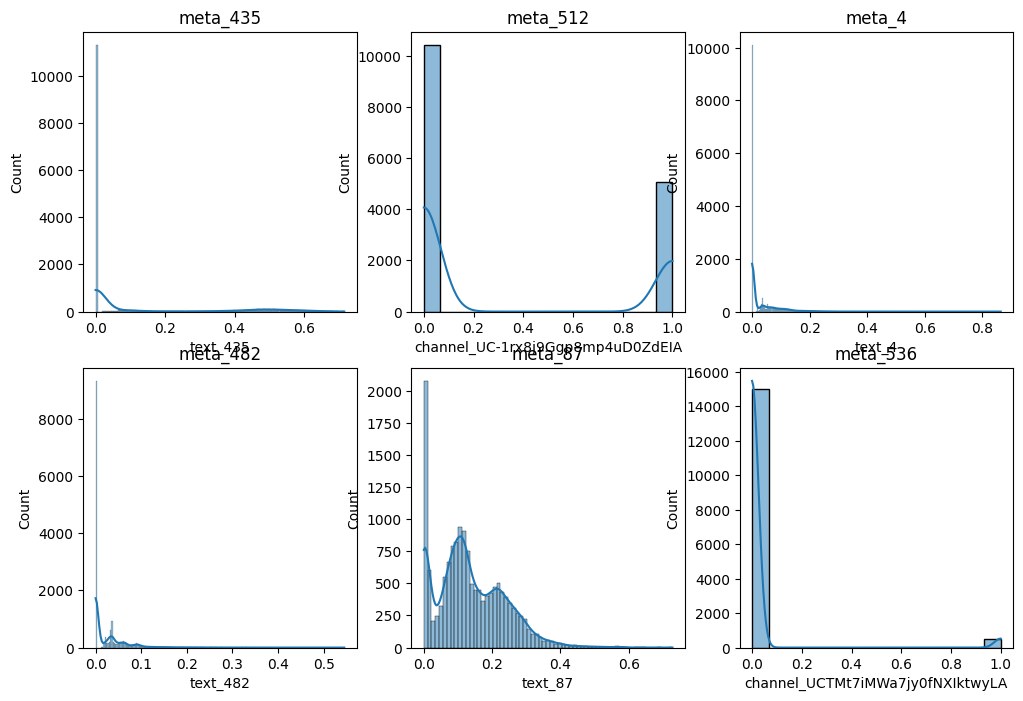

In [25]:
top_features = [435,512,4,482,87,536,74,469,209,261]  # Using indices without 'meta_' prefix

# Get descriptive statistics
print(meta_df.iloc[:, top_features].describe())

# Plot distributions
import seaborn as sns
plt.figure(figsize=(12, 8))
for i, feat_idx in enumerate(top_features, 1):
    plt.subplot(2, 3, i)
    sns.histplot(meta_df.iloc[:, feat_idx], kde=True)
    plt.title(f'meta_{feat_idx}')
plt.tight_layout()
plt.show()
# Map SHAP feature indices to actual features:
def get_feature_name(index):
    if index < 512:
        return f"text_{index}"
    elif index < 512 + len(channel_columns):
        return channel_columns[index - 512]
    elif index == 512 + len(channel_columns):
        return "year"
    else:
        return f"unknown_{index}"

top_indices = [432, 512, 536,491,435]  # From your SHAP analysis
for idx in top_indices:
    print(f"meta_{idx} corresponds to: {get_feature_name(idx)}")

In [21]:
print("Channel categories available:", encoder.categories_[0])

Channel categories available: ['UC-1rx8j9Ggp8mp4uD0ZdEIA' 'UC-vrN89jIox3XqAKbEMeFgQ'
 'UC2zrmdd_rWlMc2rAufX9bSg' 'UC6P24bhhCmMPOcujA9PKPTA'
 'UC6qhhbnMeoOPFBf-cjUgn3g' 'UC71x8bBOwIEscxAltguHXMQ'
 'UC7sDT8jZ76VLV1u__krUutA' 'UC8P49XCWzrcRVF1kct7BneA'
 'UC9DAY2JD9zy9zKA5OtwpNtw' 'UC9pJs4nFKM9xuW_enR4hHig'
 'UCCykQNoqyABmoa3ZoaU93XA' 'UCDp2VWtNgiaTjkhfCvdZmjA'
 'UCFfovcqnybrMbIrNjyND-nA' 'UCFhLnzPQFjTtlUuf39emMfg'
 'UCHUnLXalwe66kBndfmH5cXA' 'UCIAegrInVcw19QXmblowt2g'
 'UCJF8kAS8VZ-KImRxLcvAs3w' 'UCKMV8axq3zTUmiyXav2Ytew'
 'UCMOB6uDg7e-h8OuCw8dK2_Q' 'UCN5mdjo8Odux4PvR297-K4Q'
 'UCN9-Y2E0_fLxtcWAgr89CsQ' 'UCNvn1EEO-ZgN2IHkCLnA1Ng'
 'UCO7o35HtN0bRnCP1y5NNCng' 'UCTCQA8vgOHhK9hKWsPncy7w'
 'UCTMt7iMWa7jy0fNXIktwyLA' 'UCTWiOA2IQyW_QaGv4t2UaCQ'
 'UCUrJu1fEq7kH9CBXaPH0PGw' 'UCVNNriW_Mc2prgngYZ69T0A'
 'UCW6NyJ6oFLPTnx7iGRZXDDg' 'UCWnTC8o8AycL6a2eRrKSdBg'
 'UCX894EiI3iOKez6ULmZFlOg' 'UCXLfJIEp91L-fD0gP131IaQ'
 'UCZtZ5HkDba6_zM_wpaQn60w' 'UCamfFGyiS8aGLBK4sQ661ew'
 'UCcRbWavyHkNsXdfot0yo8zw' 'UCiCnP

invalid value encountered in less


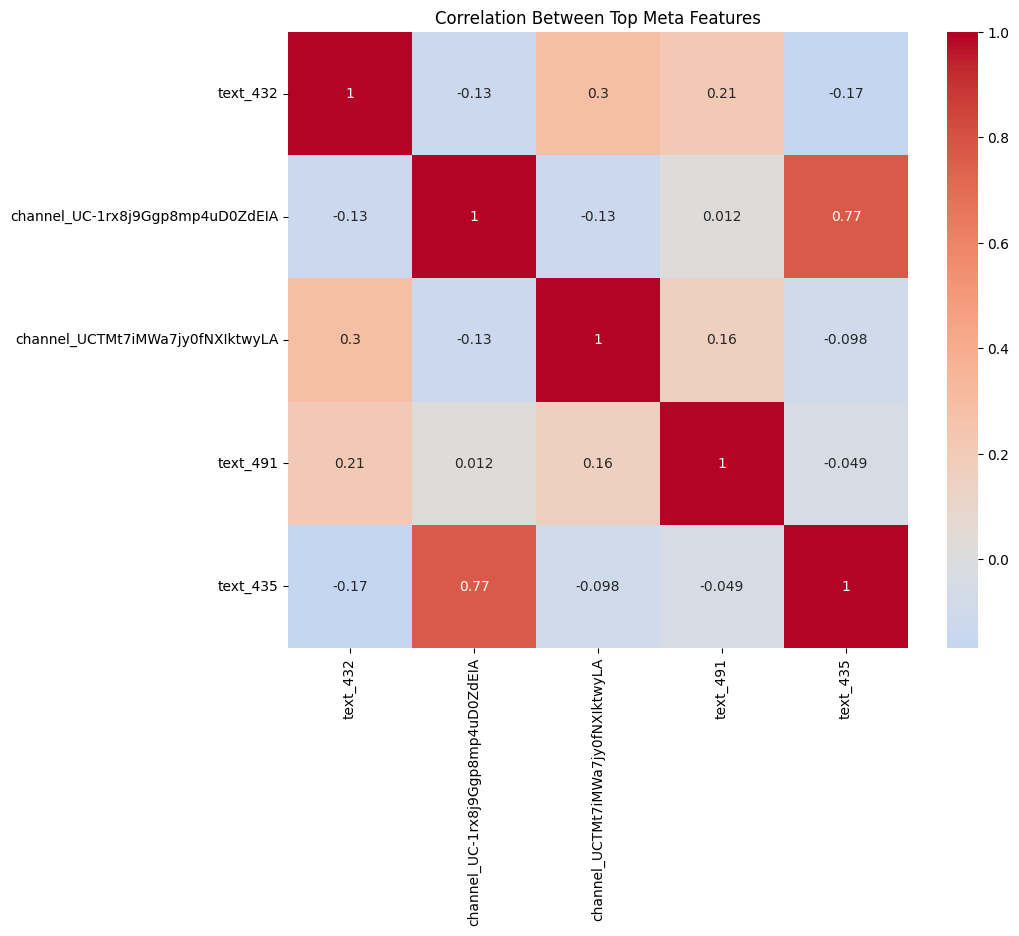

In [22]:
# Calculate correlations between top features
corr_matrix = meta_df.iloc[:, top_features].corr()

# Visualize
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Between Top Meta Features")
plt.show()

In [26]:
vectorizer = TfidfVectorizer(max_features=512).fit(train_df["text"])
feature_names = vectorizer.get_feature_names_out()
texts = [435,4,482,87,74,469,209,261]
for x in texts:
    print(f"text_{x} corresponds to: {feature_names[x]}")



text_435 corresponds to: thecgbros
text_4 corresponds to: 3d
text_482 corresponds to: we
text_87 corresponds to: com
text_74 corresponds to: cgi
text_469 corresponds to: vfxbreakdowns
text_209 corresponds to: http
text_261 corresponds to: ll


Projection en 2D

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm

# Échantillonnage 
max_samples = 1000
sample_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=True, collate_fn=clip_collate_fn_train)
sampled_images, sampled_texts = [], []

for batch in sample_loader:
    images, prompts, _ = batch
    sampled_images.extend(images)
    sampled_texts.extend(prompts)
    if len(sampled_images) >= max_samples:
        break

sampled_images = sampled_images[:max_samples]
sampled_texts = sampled_texts[:max_samples]

# Embedding extraction
model.eval()
image_embeds_list = []
text_embeds_list = []

with torch.no_grad():
    for i in range(0, len(sampled_images), 32):
        batch_images = sampled_images[i:i+32]
        batch_texts = sampled_texts[i:i+32]
        
        inputs = model.processor(
            images=batch_images,
            text=batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True
        ).to(device)

        outputs = model.clip(**inputs)
        image_embeds_list.append(outputs.image_embeds.cpu())
        text_embeds_list.append(outputs.text_embeds.cpu())

# Stack all
image_embeds = torch.cat(image_embeds_list).numpy()
text_embeds = torch.cat(text_embeds_list).numpy()

# Concatenate embeddings and prepare labels
embeds = np.vstack([image_embeds, text_embeds])
labels = ["Image"] * len(image_embeds) + ["Text"] * len(text_embeds)

# t-SNE projection
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeds_2d = tsne.fit_transform(embeds)

plt.figure(figsize=(10, 6))
for label, color in zip(["Image", "Text"], ["blue", "green"]):
    idxs = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(embeds_2d[idxs, 0], embeds_2d[idxs, 1], label=label, alpha=0.6, s=20, c=color)

plt.title("Projection 2D des embeddings CLIP (t-SNE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
